# Module 6 Assignment 1 - Digit Recognizer 

Jonathan Sax <br>
Northwestern University<br>
Practical Machine Learning - MSDS 422<br>
5/8/2022 

## Background Materials

The classic MNIST Digit Recognizer (https://www.kaggle.com/competitions/digit-recognizer) problem is a competition on Kaggle.com, and you will compete in this competition. For this assignment, you will develop a classifier that may be used to predict which of the 10 digits is being written.

## Requirements


1. Fit a random forest classifier using the full set of explanatory variables and the model training set (csv).

2. Record the time it takes to fit the model and then evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

3. Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the explanatory variables.

4. Record the time it takes to identify the principal components.

5. Using the identified principal components from step (2), use the csv to build another random forest classifier.

6. Record the time it takes to fit the model and to evaluate the model on the csvdata by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

7. Use k-means clustering to group MNIST observations into 1 of 10 categories and then assign labels.  (Follow the example here if needed: kmeans mnist.pdf Download kmeans mnist.pdf ).kmeans mnist-2.pdf Download kmeans mnist-2.pdf  

8. Submit the RF Classifier, the PCA RF, and k-means estimations to Kaggle.com, and provide screen snapshots of your scores as well as your Kaggle.com user name.

9. The experiment we have proposed has a major design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. 

Report total elapsed time measures for the training set analysis. It is sufficient to run a single time-elapsed test for this assignment. In practice, we might consider the possibility of repeated executions of the relevant portions of the programs, much as the Benchmark Example programs do. Some code that might help you with reporting elapsed total time follows. 

start=datetime.now() <br> 
rf2.fit(trainimages,labels) <br> 
end=datetime.now() <br> 
print(end-start)

## Ingest

In [95]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [96]:
test = pd.read_csv("test.csv")
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
train = pd.read_csv("train.csv")
train.shape

(42000, 785)

## EDA

In [98]:
train_df_X = train.copy()
train_df_y = train_df_X['label']
train_df_X.drop(['label'], axis=1, inplace=True)

In [99]:
train_df_X.shape

(42000, 784)

In [100]:
train_df_y.shape

(42000,)

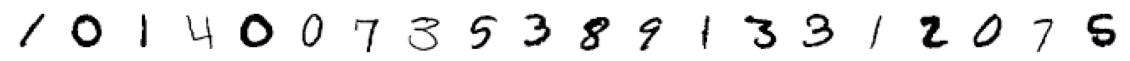

In [101]:
# there are 784 features pixels for each sample, sqrt(784) = 28
# each sample represents a 28x28 image of a digit, need to reshape
train_df_X_img = train_df_X.values.reshape(-1,28,28,1)

num_examples = 20
plt.figure(figsize=(20,20))
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.imshow(train_df_X_img[i], cmap='Greys')
    plt.axis('off')
plt.show()



Text(0.5, 1.0, 'Digit Distribution - Training Set')

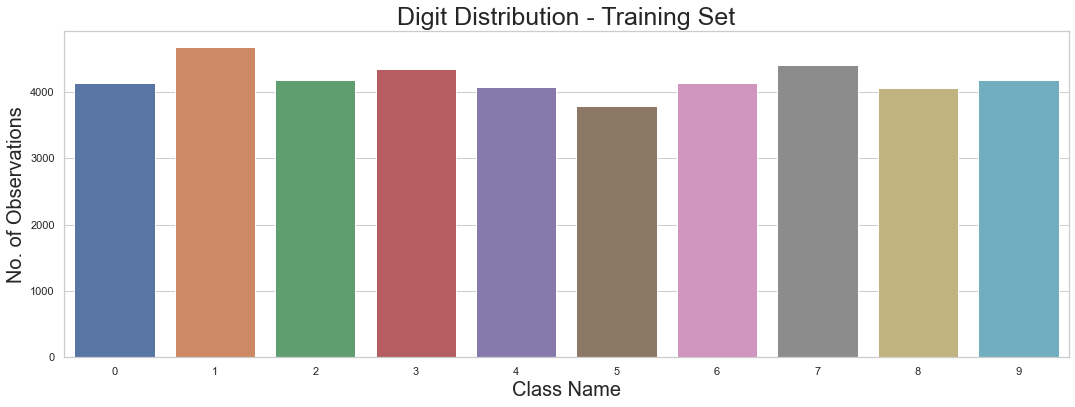

In [102]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='label', data=train);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Class Name", size=20);
plt.title("Digit Distribution - Training Set", size=25)

In [103]:
X_test_csv = test.values

In [104]:
X_test_csv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Modeling

In [105]:
X_train,X_val,y_train,y_val=train_test_split(train_df_X,train_df_y,test_size=0.2,random_state=42)

### Random Forest Classifier

In [106]:
start=datetime.now()
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train,y_train)
end=datetime.now()
print(end-start)

0:00:17.973666


In [107]:
start=datetime.now()
y_pred = rfc_model.predict(X_val)
end=datetime.now()
print(end-start)
print('accuracy score = ', accuracy_score(y_val,y_pred))

0:00:00.285560
accuracy score =  0.9628571428571429


In [108]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       816
           1       0.98      0.99      0.99       909
           2       0.96      0.96      0.96       846
           3       0.96      0.95      0.96       937
           4       0.96      0.97      0.96       839
           5       0.96      0.96      0.96       702
           6       0.96      0.98      0.97       785
           7       0.97      0.95      0.96       893
           8       0.95      0.95      0.95       835
           9       0.93      0.94      0.94       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



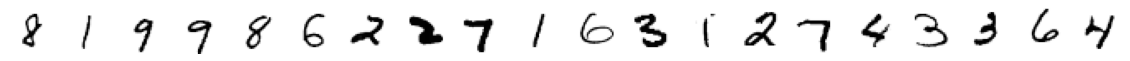

In [109]:
X_val_img = X_val.values.reshape(-1,28,28,1)

num_examples = 20
plt.figure(figsize=(20,20))
for i in range(num_examples):
    plt.subplot(1, num_examples, i+1)
    plt.imshow(X_val_img[i], cmap='Greys')
    plt.axis('off')
plt.show()

In [110]:
y_pred[0:20]


array([8, 1, 9, 9, 8, 6, 2, 2, 7, 1, 6, 3, 1, 2, 7, 4, 3, 3, 6, 4])

In [111]:
y_val[0:20]

5457     8
38509    1
25536    9
31803    9
39863    8
30639    6
12986    2
41067    2
30743    7
6839     1
17164    6
21723    3
12272    1
5030     2
25222    7
34680    4
4976     3
19565    3
27947    6
31133    4
Name: label, dtype: int64

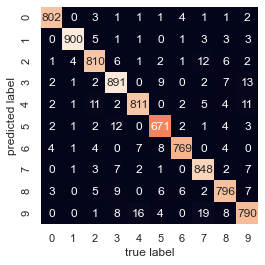

In [112]:
mat = confusion_matrix(y_val, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [113]:
start=datetime.now()
y = rfc_model.predict(test)
end=datetime.now()
print(end-start)

0:00:00.991360


In [60]:
# create submission file
submission = pd.DataFrame({"ImageId": (test.index + 1),"Label": y})
submission.to_csv('submissionRFC.csv', index=False)

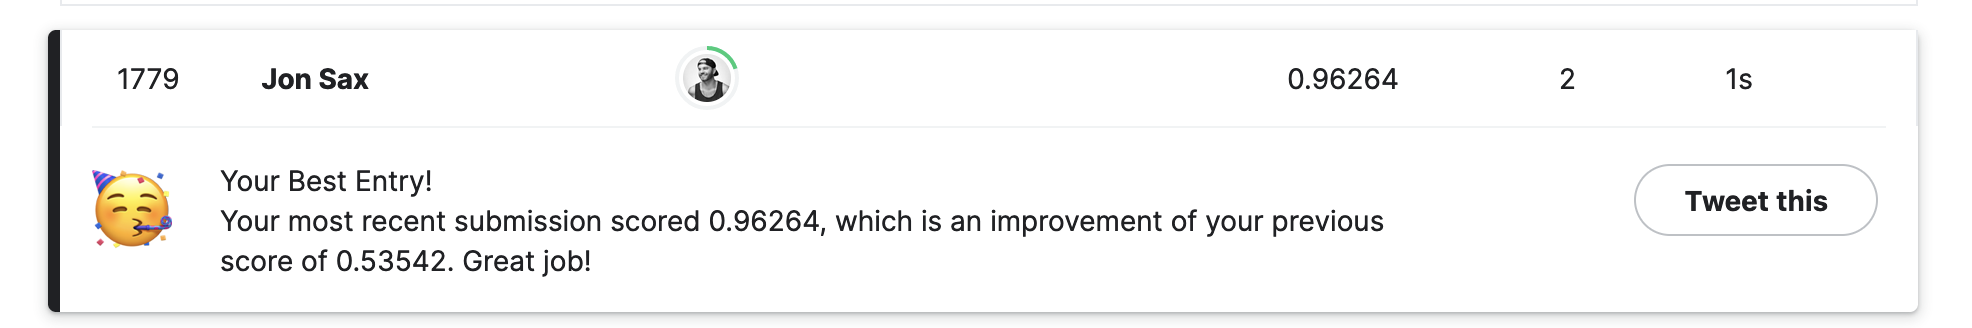

Kaggle username = jonsax88

## Principal Component Analysis (PCA)

In [62]:
start=datetime.now()
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
pca_n_components = np.argmax(cumsum >= 0.95) + 1
end=datetime.now()
print('Time: ', end-start)
print('# PCA Components at 95% variability: ', pca_n_components)

Time:  0:00:02.004420
# PCA Components at 95% variability:  153


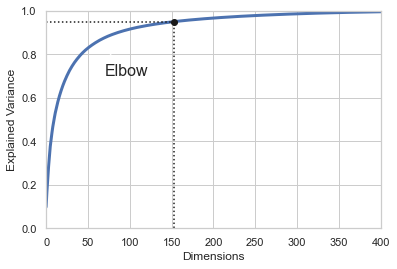

In [63]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([pca_n_components, pca_n_components], [0, 0.95], "k:")
plt.plot([0, pca_n_components], [0.95, 0.95], "k:")
plt.plot(pca_n_components, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [64]:
start=datetime.now()
pca = PCA(n_components=pca_n_components)
X_train_pca = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_train_pca)
end=datetime.now()
print('Time: ', end-start)

Time:  0:00:02.075423


## PCA of test and train dataset combined

In [65]:
rnd_clf_pca = RandomForestClassifier(n_estimators=100, random_state=42)

start=datetime.now()
rnd_clf_pca.fit(X_train_pca, y_train)
end=datetime.now()
print(end-start)



0:00:36.787805


In [73]:
X_test_reduced = pca.transform(X_val)

y_pred_reduced = rnd_clf_pca.predict(X_test_reduced)
accuracy_score(y_val, y_pred_reduced)

0.9380952380952381

In [78]:
X_test_reduced_csv = pca.transform(X_test_csv)
y_pred_reduced_csv = rnd_clf_pca.predict(X_test_reduced_csv)

In [80]:
# create submission file
submission2 = pd.DataFrame({"ImageId": (test.index + 1),"Label": y_pred_reduced_csv})
submission2.to_csv('submission_pcs_rf.csv', index=False)

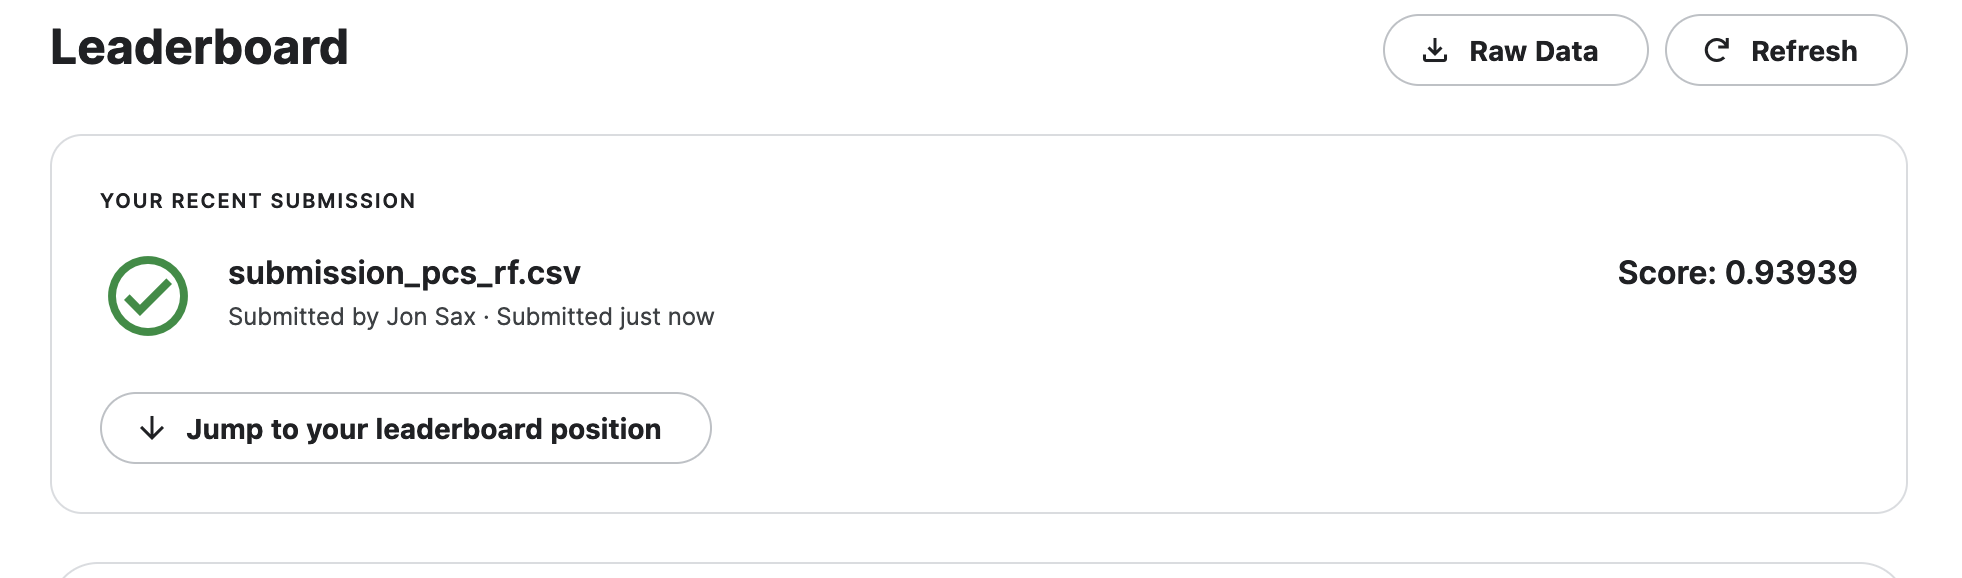

## K-Means Clustering

In [32]:
n_digits = len(np.unique(y_val))
print(n_digits)

10


In [41]:
start=datetime.now()

# Initialize Kmeans model

kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data

kmeans.fit(X_train)

kmeans.labels_

end=datetime.now()
print(end-start)


0:00:00.625563


In [42]:
y_train_clusters = pd.DataFrame(kmeans.labels_, columns=["Cluster"])
y_train_clusters['Label'] = y_train.tolist()
y_train_clusters

,Cluster,Label
0,4,6
1,0,5
2,9,3
3,3,4
4,3,7
...,...,...
33595,5,9
33596,3,9
33597,6,2
33598,4,6


In [43]:
pd.crosstab(y_train_clusters['Cluster'],y_train_clusters["Label"])

Label,0,1,2,3,4,5,6,7,8,9
Cluster,,,,,,,,,,
0,31,10,80,474,5,719,14,4,1805,46
1,7,967,1842,165,55,122,65,109,450,22
2,1150,0,631,219,13,276,109,7,107,15
3,8,4,26,78,946,131,0,1521,39,1501
4,146,6,132,47,73,101,2314,2,29,7
5,7,6,32,30,912,392,1,1505,196,1032
6,53,3,246,27,1143,73,673,190,53,592
7,6,2775,196,214,85,310,123,162,184,95
8,1811,0,8,5,0,23,42,4,13,10


In [44]:
key = y_train_clusters.groupby('Cluster').agg(lambda x:x.value_counts().index[0])
key 

,Label
Cluster,
0,8
1,2
2,0
3,7
4,6
5,7
6,4
7,1
8,0


In [45]:
y_train_labels = []
for i in range(0,len(kmeans.labels_)):
    x = kmeans.labels_[i]
    y_train_labels += [key['Label'].loc[x]]

print(classification_report(y_train, y_train_labels))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76      3316
           1       0.67      0.74      0.70      3775
           2       0.48      0.55      0.52      3331
           3       0.58      0.63      0.60      3414
           4       0.37      0.35      0.36      3233
           5       0.00      0.00      0.00      3093
           6       0.81      0.69      0.75      3352
           7       0.36      0.86      0.51      3508
           8       0.57      0.56      0.56      3228
           9       0.00      0.00      0.00      3350

    accuracy                           0.54     33600
   macro avg       0.45      0.53      0.48     33600
weighted avg       0.46      0.54      0.48     33600



/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
y_val_pred = kmeans.predict(X_val)
y_val_pred

array([1, 7, 3, ..., 9, 8, 3], dtype=int32)

In [47]:
y_val_labels = []
for i in range(0,len(y_val_pred)):
    x = y_val_pred[i]
    y_val_labels += [key['Label'].loc[x]]

print(classification_report(y_val, y_val_labels))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       816
           1       0.68      0.77      0.72       909
           2       0.49      0.54      0.51       846
           3       0.61      0.64      0.63       937
           4       0.38      0.34      0.36       839
           5       0.00      0.00      0.00       702
           6       0.79      0.67      0.72       785
           7       0.37      0.89      0.52       893
           8       0.60      0.57      0.58       835
           9       0.00      0.00      0.00       838

    accuracy                           0.54      8400
   macro avg       0.46      0.53      0.48      8400
weighted avg       0.47      0.54      0.49      8400



/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
Kmeans_pred = kmeans.predict(test)

test_labels = []
for i in range(0,len(Kmeans_pred)):
    x = Kmeans_pred[i]
    test_labels += [key['Label'].loc[x]]

In [51]:
# create submission file
submission = pd.DataFrame({"ImageId": (test.index + 1),"Label": test_labels})
submission.to_csv('submission.csv', index=False)

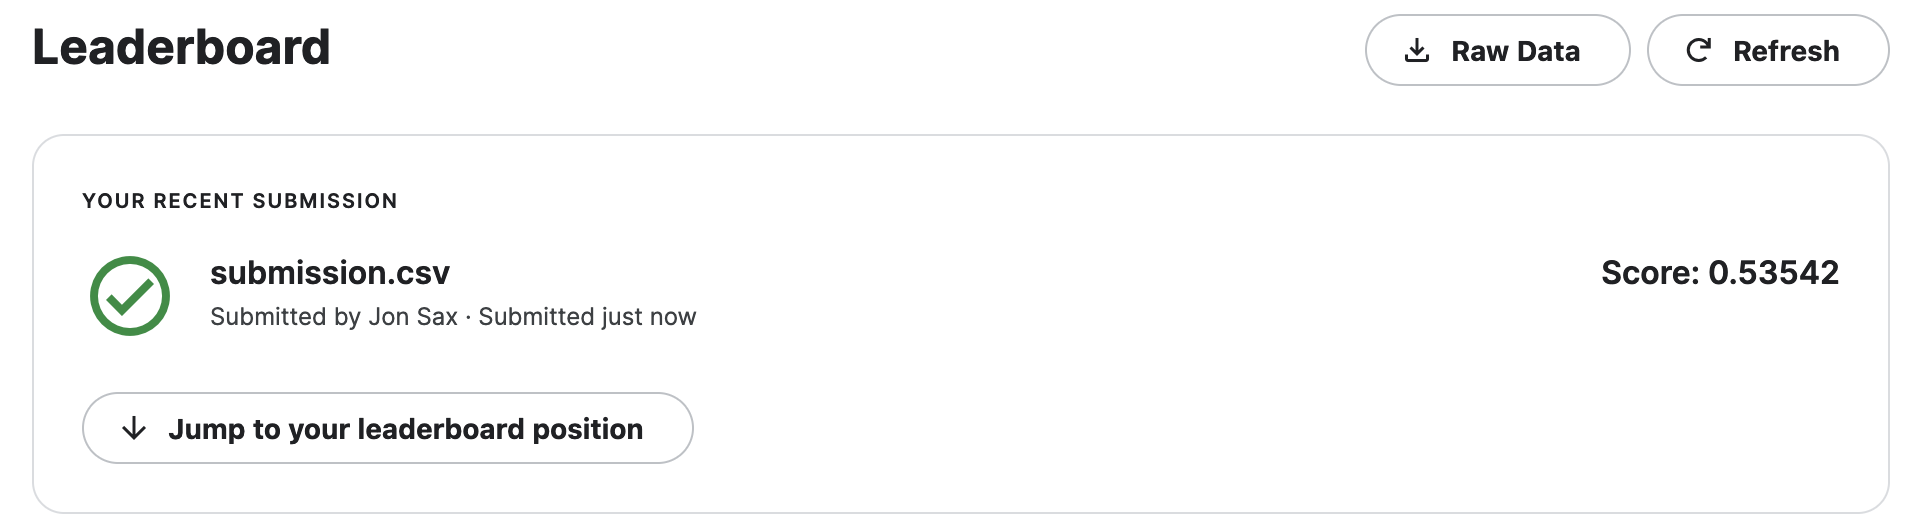

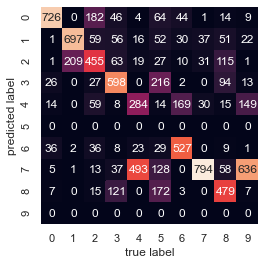

In [81]:
mat2 = confusion_matrix(y_val, y_val_labels)
sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Design Flaw

Perhaps the design flaw is the fact that the K-means clustering needs more clusters:

In [127]:
start=datetime.now()
# kmeans_fix = KMeans(n_clusters=10)
# - MiniBatchKMeans: super-fast but has memory leaks (use batch_size=2048 to resolve) 
# - In my experience not as accurate; same n_clusters value used in KMeans() would 
#   be more accurate than MiniBatchKMeans() but extremely slow at higer n_clusters values
# - trade-off: use much higher n_clusters in MiniBatchKMeans() to increase accuracy 
#   but will process it much faster than KMeans() 
kmeans_fix = MiniBatchKMeans(n_clusters=3000, batch_size=2048)
kmeans_fix.fit(X_train)
end=datetime.now()
print(end-start)
print(kmeans_fix.labels_)

0:00:58.577347
[ 186  763  240 ... 1052  330  402]


In [128]:
y_train_clusters_fix = pd.DataFrame(kmeans_fix.labels_, columns=["Cluster"])
y_train_clusters_fix['Label'] = y_train.tolist()
y_train_clusters_fix

,Cluster,Label
0,186,6
1,763,5
2,240,3
3,2343,4
4,44,7
...,...,...
33595,1095,9
33596,1938,9
33597,1052,2
33598,330,6


In [129]:
pd.crosstab(y_train_clusters_fix['Cluster'],y_train_clusters_fix["Label"])

Label,0,1,2,3,4,5,6,7,8,9
Cluster,,,,,,,,,,
0,8,0,0,0,0,1,0,0,1,0
1,0,17,0,0,5,0,0,0,1,1
2,0,0,0,0,0,3,0,0,14,0
3,30,0,0,0,0,0,0,0,0,0
4,0,0,0,0,24,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,15,0,0
2996,0,0,0,1,0,0,0,0,0,0
2997,0,0,0,0,0,0,1,0,0,0


In [130]:
key_fix = y_train_clusters.groupby('Cluster').agg(lambda x:x.value_counts().index[0])
key_fix 

,Label
Cluster,
0,8
1,2
2,0
3,7
4,6
5,7
6,4
7,1
8,0


In [131]:
kmeans_fix.labels_

array([ 186,  763,  240, ..., 1052,  330,  402], dtype=int32)

In [132]:
key_fix.shape

(10, 1)

In [136]:
y_test_pred_fix = kmeans_fix.predict(X_val)
y_test_pred_fix

array([2862,   46,  602, ...,  572, 2960,  843], dtype=int32)

In [137]:
y_test_labels_fix = []
for i in range(0,len(y_test_pred_fix)):
    x = y_test_pred_fix[i]
    try:
        y_test_labels_fix += [key_fix['Label'].loc[x]]
    except KeyError:
        y_test_labels_fix += [0]

In [139]:
print(classification_report(y_val, y_test_labels_fix))

              precision    recall  f1-score   support

           0       0.10      0.99      0.18       816
           1       0.00      0.00      0.00       909
           2       0.00      0.00      0.00       846
           3       0.00      0.00      0.00       937
           4       0.20      0.00      0.00       839
           5       0.00      0.00      0.00       702
           6       0.00      0.00      0.00       785
           7       0.46      0.01      0.01       893
           8       0.00      0.00      0.00       835
           9       0.00      0.00      0.00       838

    accuracy                           0.10      8400
   macro avg       0.08      0.10      0.02      8400
weighted avg       0.08      0.10      0.02      8400



/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion

It makes sense that my best model was the regular Random Forests classifier. The updated RF classifier that only uses the Principle Components doesn't have as many features / dimensions, making it slightly less accurate than the original RF classifier. Meanwhile, as you can see in the above confusion matrix of my K-means clustering model, that was the least accurate model.